In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import os

# 1. Data

In [2]:
class BloodDataset(Dataset):
    """
    Custom dataset for blood cell images (self-supervised learning)
    """
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.data = datasets.ImageFolder(root, transform=transform)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, _ = self.data[idx]  # Ignore the label
        return image

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    transforms.ToTensor()
])

train_dataset = BloodDataset('/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN', transform=transform)
test_dataset = BloodDataset('/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
def imshow(img, label=None):
    img = img.cpu().numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if label:
        plt.title(label)
    plt.show()
def show_batch(batch):
    images = batch
    grid = torchvision.utils.make_grid(images)
    imshow(grid)

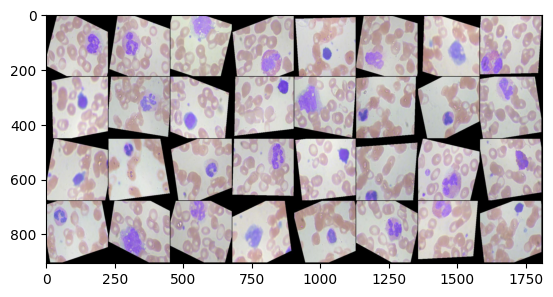

In [5]:
batch = next(iter(train_loader))
show_batch(batch)

# 2. Model

In [6]:
from torchvision.models import resnet18
from torchvision.models import ResNet18_Weights

In [7]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss (SimCLR)
    """
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, z_i, z_j, temperature=0.5):
        N = len(z_i)
        z = torch.cat([z_i, z_j], dim=0)
        sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)
        sim_i_j = torch.diag(sim, N)
        sim_j_i = torch.diag(sim, -N)
        positive = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(2*N, 1)
        negative = sim[torch.ones(2*N, dtype=torch.bool)].reshape(2*N, -1)
        logits = torch.cat((positive, negative), dim=1)
        logits /= temperature
        labels = torch.zeros(2*N, dtype=torch.long, device=z.device)
        loss = F.cross_entropy(logits, labels)
        return loss

In [8]:
class BloodSimNet(nn.Module):
    """
    BloodSimNet model
    """

    def __init__(self, projection_dim=64, use_max=True):
        super(BloodSimNet, self).__init__()
        self.base_encoder = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.base_encoder = nn.Sequential(*list(self.base_encoder.children())[:-1])
        self.pool = nn.AdaptiveMaxPool2d(1) if use_max else nn.AdaptiveAvgPool2d(1)
        self.projector = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, projection_dim),
        )

    def forward(self, x):
        z = self.base_encoder(x)
        z = z.view(z.size(0), -1)
        z = self.projector(z)
        z = F.normalize(z, p=2, dim=1)
        return z

    def __str__(self):
        return "SimCLR"

In [9]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using device:', torch.cuda.get_device_name(0))
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Using device:', device)

Using device: Tesla P100-PCIE-16GB
Using device: cuda


In [10]:
model = BloodSimNet().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


# 3. Training

In [11]:
def data_augmentation(img):
    """
    Data augmentation function
    :param img: the input image
    :return: the augmented image
    """
    # Perform data augmentation here
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0), antialias=True),
    ])
    if img.device.type == 'mps': # mps not supported. See https://github.com/pytorch/pytorch/issues/77764
        augmented_img = transform(img.cpu()).to(img.device)
    else:
        augmented_img = transform(img)
    return augmented_img

In [12]:
# Training loop
def train(model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(tqdm(train_loader, total=len(train_loader), desc='Training')):
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Data augmentation
        x1 = data_augmentation(batch).to(device)
        x2 = data_augmentation(batch).to(device)
        
        # Forward pass
        z1 = model(x1)
        z2 = model(x2)
        
        # Compute loss
        loss = criterion(z1, z2)
        
        # Backward pass
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        running_loss += loss.item()
        
    return running_loss / len(train_loader)

In [13]:
# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    loss = train(model, criterion, optimizer, train_loader, device)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss}')
    
    # Save the model
    if os.path.exists(f'/kaggle/working/models/{model}') is False:
        os.makedirs(f'/kaggle/working/models/{model}')
    torch.save(model.state_dict(), f'models/{model}/{model}-{epoch+1}.pth')

Training: 100%|██████████| 312/312 [03:32<00:00,  1.47it/s]


Epoch 1/5, Loss: 2.5772404063206453


Training: 100%|██████████| 312/312 [03:06<00:00,  1.68it/s]


Epoch 2/5, Loss: 2.488407083046742


Training: 100%|██████████| 312/312 [03:06<00:00,  1.67it/s]


Epoch 3/5, Loss: 2.4693287118123126


Training: 100%|██████████| 312/312 [03:06<00:00,  1.68it/s]


Epoch 4/5, Loss: 2.4595519594657116


Training: 100%|██████████| 312/312 [03:05<00:00,  1.68it/s]

Epoch 5/5, Loss: 2.4508647933984413


In [14]:
from sklearn.manifold import TSNE

In [15]:
# Test the model
model.eval()
embeddings = []

with torch.no_grad():
    for batch in tqdm(test_loader, total=len(test_loader), desc='Testing'):
        batch = batch.to(device)
        embeddings.append(model(batch).cpu().numpy())
        
embeddings = np.concatenate(embeddings)

Testing: 100%|██████████| 78/78 [00:13<00:00,  5.73it/s]


In [16]:
# Apply K-means clustering to the embeddings
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
pseudo_labels = kmeans.fit(embeddings)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [17]:
# Visualize the embeddings using t-SNE
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(embeddings)

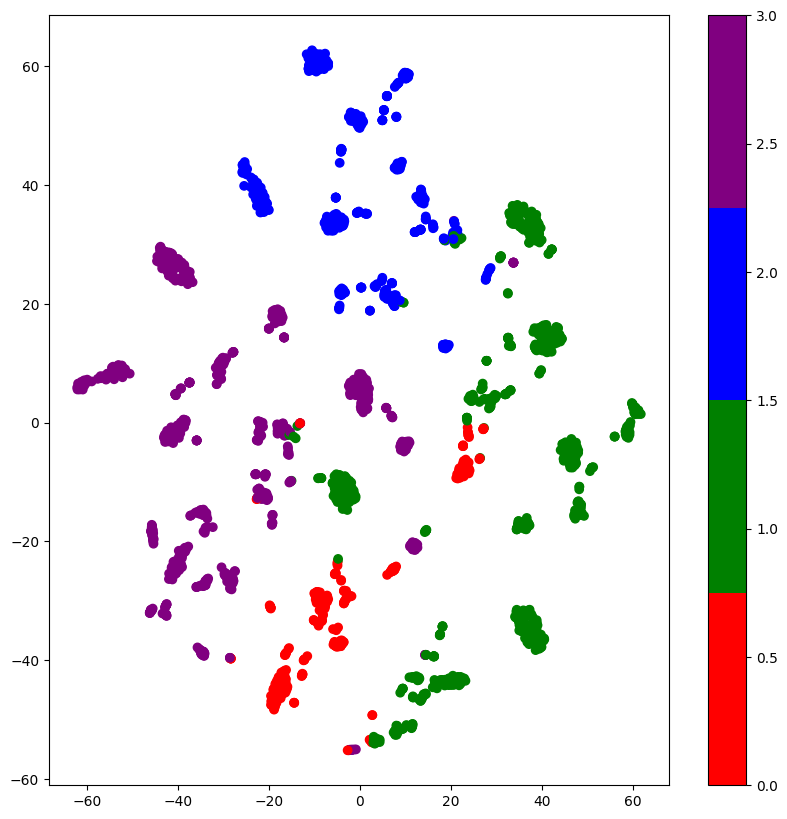

In [18]:
plt.figure(figsize=(10, 10))
colors = ['red', 'green', 'blue', 'purple']
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=pseudo_labels.labels_, cmap=matplotlib.colors.ListedColormap(colors))
plt.colorbar()
plt.show()